# Set up

In [2]:
import datetime as dt
import numpy as np

from collections import Counter

from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import pandas as pd
import pandas.io.sql as pd_sql

# Connect to SQL DB

In [3]:
params = {
    'host': '127.0.0.1',
    'port': 5432
}

connection = connect(**params, dbname='cb')

## Get company data

In [4]:
query = "SELECT * FROM cb_objects;"

companies=pd_sql.read_sql(query, connection)

In [5]:
companies.columns

Index(['id', 'entity_type', 'entity_id', 'parent_id', 'name',
       'normalized_name', 'permalink', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'homepage_url', 'twitter_username', 'logo_url',
       'logo_width', 'logo_height', 'short_description', 'description',
       'overview', 'tag_list', 'country_code', 'state_code', 'city', 'region',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'relationships', 'created_by',
       'created_at', 'updated_at'],
      dtype='object')

In [6]:
select_df=companies[['id', 'name', 'category_code', 'status', 'founded_at','closed_at', 'region',
       'first_funding_at']]

In [7]:
select_df.count()

id                  462651
name                462651
category_code       123186
status              462651
founded_at          100441
closed_at             2809
region              462651
first_funding_at     31507
dtype: int64

In [8]:
select_df.status.unique()

array(['operating', 'acquired', 'closed', 'ipo', 'live', 'beta',
       'private', 'alpha', 'development'], dtype=object)

In [9]:
select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462651 entries, 0 to 462650
Data columns (total 8 columns):
id                  462651 non-null object
name                462651 non-null object
category_code       123186 non-null object
status              462651 non-null object
founded_at          100441 non-null object
closed_at           2809 non-null object
region              462651 non-null object
first_funding_at    31507 non-null object
dtypes: object(8)
memory usage: 28.2+ MB


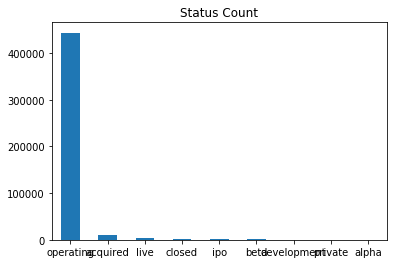

In [187]:
counts=select_df.status.value_counts()
counts.plot(kind='bar', title='Status Count', rot=0);

## Get investment data

To gather:
Per funding round:
- months active
- funding rounds thus far
- current round #
- total funding thus far
- valuation diff

In [10]:
query2 = "SELECT * FROM cb_funding_rounds;"

funding=pd_sql.read_sql(query2, connection)

In [11]:
funding.funding_round_type.unique()

array(['series-b', 'angel', 'series-a', 'series-c+', 'venture', 'other',
       'private-equity', 'post-ipo', 'crowdfunding'], dtype=object)

In [12]:
funding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52928 entries, 0 to 52927
Data columns (total 23 columns):
id                          52928 non-null float64
funding_round_id            52928 non-null float64
object_id                   52928 non-null object
funded_at                   52680 non-null object
funding_round_type          52928 non-null object
funding_round_code          52928 non-null object
raised_amount_usd           46928 non-null float64
raised_amount               47290 non-null float64
raised_currency_code        49862 non-null object
pre_money_valuation_usd     42 non-null float64
pre_money_valuation         42 non-null float64
pre_money_currency_code     26883 non-null object
post_money_valuation_usd    1209 non-null float64
post_money_valuation        1294 non-null float64
post_money_currency_code    30448 non-null object
participants                52928 non-null int64
is_first_round              52928 non-null int64
is_last_round               52928 non-null 

In [13]:
funding['funded_at'] = pd.to_datetime(funding['funded_at'])

In [14]:
funding.sort_values(['object_id','funded_at'], inplace=True)

In [36]:
funding_stats=funding[['object_id', 'funded_at', 'funding_round_type', 'raised_amount_usd',
                      'participants' ]]

In [37]:
funding_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52928 entries, 819 to 2969
Data columns (total 5 columns):
object_id             52928 non-null object
funded_at             52680 non-null datetime64[ns]
funding_round_type    52928 non-null object
raised_amount_usd     46928 non-null float64
participants          52928 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.9+ MB


In [38]:
funding_stats.head(15)

,object_id,funded_at,funding_round_type,raised_amount_usd,participants
819,c:1,2005-10-01,series-a,5250000.0,2
820,c:1,2007-01-01,series-b,9500000.0,3
2123,c:1,2008-05-19,series-c+,25000000.0,4
1525,c:1001,2008-02-26,series-a,5000000.0,3
6061,c:10014,2008-09-01,angel,NaN,1
3296,c:10015,2008-10-10,series-a,2000000.0,2
16861,c:10015,2010-09-10,series-b,9000000.0,4
49113,c:10015,2012-01-01,venture,2069200.0,4
25478,c:10015,2012-01-24,series-c+,12000000.0,4
41342,c:10015,2013-08-13,series-c+,43000000.0,5


## Get acquisition and ipo data

In [20]:
query3 = "SELECT * FROM cb_acquisitions;"

acquisition=pd_sql.read_sql(query3, connection)

In [21]:
acquisition.columns

Index(['id', 'acquisition_id', 'acquiring_object_id', 'acquired_object_id',
       'term_code', 'price_amount', 'price_currency_code', 'acquired_at',
       'source_url', 'source_description', 'created_at', 'updated_at'],
      dtype='object')

In [22]:
acquisition=acquisition[['acquired_object_id','acquired_at']]

In [23]:
query4 = "SELECT * FROM cb_ipos;"

ipo=pd_sql.read_sql(query4, connection)

In [24]:
ipo.columns

Index(['id', 'ipo_id', 'object_id', 'valuation_amount',
       'valuation_currency_code', 'raised_amount', 'raised_currency_code',
       'public_at', 'stock_symbol', 'source_url', 'source_description',
       'created_at', 'updated_at'],
      dtype='object')

In [25]:
ipo=ipo[['object_id','public_at']]

# Feature Engineering

Feature Engineering To-Do
1. Merge funding, acquisition, ipo stats to company data
2. Get yearly company data snapshots for forecasting
3. Figure out status of company looking ahead to 3-years out
4. Calculate active days since founding date per row

## Merge funding, acquisition, ipo stats to company data

In [147]:
merged_df=funding_stats.merge(select_df, how='left', left_on='object_id', right_on='id')

In [148]:
merged_df=merged_df.merge(acquisition, how='left', left_on='object_id', right_on='acquired_object_id')

In [149]:
merged_df=merged_df.merge(ipo, how='left', left_on='object_id', right_on='object_id')

In [150]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53026 entries, 0 to 53025
Data columns (total 16 columns):
object_id             53026 non-null object
funded_at             52777 non-null datetime64[ns]
funding_round_type    53026 non-null object
raised_amount_usd     47014 non-null float64
participants          53026 non-null int64
id                    52724 non-null object
name                  52724 non-null object
category_code         51259 non-null object
status                52724 non-null object
founded_at            43280 non-null object
closed_at             2943 non-null object
region                52724 non-null object
first_funding_at      52518 non-null object
acquired_object_id    5022 non-null object
acquired_at           5017 non-null object
public_at             950 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(13)
memory usage: 6.9+ MB


## Clean data

In [30]:
# ensure date datatypes are indeed dates

In [151]:
merged_df['founded_at'] = pd.to_datetime(merged_df['founded_at'])

In [152]:
merged_df['acquired_at'] = pd.to_datetime(merged_df['acquired_at'])

In [153]:
merged_df['public_at'] = pd.to_datetime(merged_df['public_at'])

In [154]:
merged_df['closed_at'] = pd.to_datetime(merged_df['closed_at'])

In [155]:
# drop rows where there is missing founding dates for a company
merged_df=merged_df[merged_df['founded_at'].notnull()]

In [156]:
# drop rows where there is missing funding date info
merged_df=merged_df[merged_df['funded_at'].notnull()]

In [157]:
# find rows where there is no info about funding round amount
merged_df[merged_df['raised_amount_usd'].isnull()]['object_id'].count()

4541

In [158]:
tmp= merged_df[merged_df['raised_amount_usd'].isnull()]['object_id'].values

In [159]:
#drop the 4541 companies with missing funding info
merged_df=merged_df[~merged_df['object_id'].isin(tmp)]

In [160]:
merged_df.to_pickle('../data/interim/data_for_exploration.pkl')

## Get yearly company data snapshots for forecasting

In [161]:
merged_df.sort_values(by=['object_id', 'funded_at'], inplace=True)

In [162]:
# get cumulative raised sums
merged_df['raised_sum']=merged_df.groupby('object_id')['raised_amount_usd'].cumsum()

In [163]:
merged_df['round_rank']=merged_df.groupby('object_id').cumcount()+1

In [164]:
merged_df.head()

,object_id,funded_at,funding_round_type,raised_amount_usd,participants,id,name,category_code,status,founded_at,closed_at,region,first_funding_at,acquired_object_id,acquired_at,public_at,raised_sum,round_rank
0,c:1,2005-10-01,series-a,5250000.0,2,c:1,Wetpaint,web,operating,2005-10-17,NaT,Seattle,2005-10-01,NaN,NaT,NaT,5250000.0,1
1,c:1,2007-01-01,series-b,9500000.0,3,c:1,Wetpaint,web,operating,2005-10-17,NaT,Seattle,2005-10-01,NaN,NaT,NaT,14750000.0,2
2,c:1,2008-05-19,series-c+,25000000.0,4,c:1,Wetpaint,web,operating,2005-10-17,NaT,Seattle,2005-10-01,NaN,NaT,NaT,39750000.0,3
3,c:1001,2008-02-26,series-a,5000000.0,3,c:1001,FriendFeed,web,acquired,2007-10-01,NaT,SF Bay,2008-02-26,c:1001,2009-08-10,NaT,5000000.0,1
5,c:10015,2008-10-10,series-a,2000000.0,2,c:10015,Fitbit,health,operating,2007-10-01,NaT,SF Bay,2008-10-10,NaN,NaT,NaT,2000000.0,1


In [165]:
merged_df['founded_at'].describe()

count                   35806
unique                   2136
top       2007-01-01 00:00:00
freq                     1842
first     1903-01-01 00:00:00
last      2014-01-01 00:00:00
Name: founded_at, dtype: object

In [166]:
last_date = dt.datetime(2014, 1, 1, 0, 0)

In [167]:
# create last known status row for each company (e.g. acquired, operating, closed, or ipo-ed)
merged_df['last_status_date']=merged_df[['closed_at', 'acquired_at', 'public_at']].values.max(1)

In [168]:
merged_df['last_status_date'].fillna(last_date, inplace=True)

In [169]:
merged_df['days_active']=(merged_df['funded_at']-merged_df['founded_at'])/ np.timedelta64(1, 'D')

In [170]:
# add rows to account for the last known status date for a company
rows_to_add=merged_df.groupby(by='object_id').tail(1)

In [171]:
rows_to_add.loc['days_active']=(rows_to_add['last_status_date']-rows_to_add['founded_at'])/ np.timedelta64(1, 'D')

/Users/pyt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [113]:
rows_to_add.set_index('last_status_date', inplace=True)

In [114]:
rows_to_add=rows_to_add.drop(columns=['funded_at'])

In [115]:
# make the last_status_date the "funded_at" date for now so that funding data can be merged
rows_to_add.index.names = ['funded_at']

In [116]:
rows_to_add.head()

,object_id,funding_round_type,raised_amount_usd,participants,id,name,category_code,status,founded_at,closed_at,region,first_funding_at,acquired_object_id,acquired_at,public_at,raised_sum,round_rank,days_active
funded_at,,,,,,,,,,,,,,,,,,
2014-01-01,c:1,series-c+,25000000.0,4,c:1,Wetpaint,web,operating,2005-10-17,NaT,Seattle,2005-10-01,NaN,NaT,NaT,39750000.0,3,2998.0
2009-08-10,c:1001,series-a,5000000.0,3,c:1001,FriendFeed,web,acquired,2007-10-01,NaT,SF Bay,2008-02-26,c:1001,2009-08-10,NaT,5000000.0,1,679.0
2014-01-01,c:10015,series-c+,43000000.0,5,c:10015,Fitbit,health,operating,2007-10-01,NaT,SF Bay,2008-10-10,NaN,NaT,NaT,68069200.0,5,2284.0
2014-01-01,c:100155,series-b,3250000.0,2,c:100155,MTPV,cleantech,operating,2003-01-01,NaT,Austin,2011-03-08,NaN,NaT,NaT,10125293.0,3,4018.0
2014-01-01,c:10018,series-c+,15000000.0,6,c:10018,Demandbase,analytics,operating,2006-01-01,NaT,SF Bay,2008-08-25,NaN,NaT,NaT,33000000.0,3,2922.0


In [117]:
merged_df=merged_df.set_index('funded_at')

In [118]:
merged_df=merged_df.append(rows_to_add, sort=True)

/Users/pyt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [119]:
merged_df.sort_values(by=['object_id', 'funded_at'], inplace=True)

In [120]:
#sample to yearly snapshot data
merged_df2=merged_df.groupby('object_id').resample('1Y').bfill()

In [121]:
merged_df3=merged_df2.reset_index(drop=True, level=0)

In [122]:
merged_df4=merged_df3.reset_index()

In [123]:
merged_df4.sort_values(by=['object_id', 'funded_at'], inplace=True)

In [124]:
merged_df4['yearly_status']='operating'

In [125]:
# set status to what will happen in 3 years out
g = merged_df4.groupby('object_id')
merged_df4.loc[g.tail(3).index, 'yearly_status'] = merged_df4.loc[g.tail(3).index, 'status']

In [127]:
merged_df4['days_active']=(merged_df4['funded_at']-merged_df4['founded_at'])/ np.timedelta64(1, 'D')

In [175]:
merged_df4.count()

funded_at             94217
acquired_at            5847
acquired_object_id     5860
category_code         72043
closed_at              3845
days_active           73901
first_funding_at      73901
founded_at            73901
funding_round_type    73901
id                    73901
last_status_date      19691
name                  73901
object_id             73901
participants          73901
public_at              1339
raised_amount_usd     73901
raised_sum            73901
region                73901
round_rank            73901
status                73901
yearly_status         94214
dtype: int64

In [176]:
# filter out companies that are established before 1990
merged_df4=merged_df4[merged_df4['founded_at']>'1990-01-01']

## Pickle data before final cleaning and dropping n/a data

In [177]:
merged_df4.to_pickle('../data/interim/data_for_modeling_prep.pkl')

# Clean and drop irrelevant data

In [188]:
df=merged_df4

In [118]:
# dropp columns
df=df.drop(columns=['object_id', 'funding_round_type', 'raised_amount_usd','object_id', 
                                 'founded_at','id', 'name', 'founded_at',
                        'closed_at', 'first_funding_at', 'funded_at', 'status', 'public_at', 'last_status_date', 'acquired_at',
                                'acquired_object_id'])

In [119]:
# need to fill in null values
df['category_code'].fillna('None', inplace=True)

In [120]:
df=df[(df['days_active'].notna())]

In [121]:
df['yearly_status'].unique()

array(['operating', 'acquired', 'closed', 'ipo'], dtype=object)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71717 entries, 0 to 94215
Data columns (total 7 columns):
category_code    71717 non-null object
days_active      71717 non-null float64
participants     71717 non-null float64
raised_sum       71717 non-null float64
region           71717 non-null object
round_rank       71717 non-null float64
yearly_status    71717 non-null object
dtypes: float64(4), object(3)
memory usage: 4.4+ MB


In [123]:
print("Number of categories: "+str(np.unique(df.category_code.values).size))

Number of categories: 43


In [124]:
print("Number of region: "+str(np.unique(df.region.values).size))

Number of region: 1758


In [125]:
df.loc[~(df['category_code'].isin(['software', 'web', 'mobile', 'biotech', 'games_video', 'enterprise',
       'advertising', 'ecommerce', 'network_hosting', 'hardware'])),['category_code']]="other"

In [126]:
print("Number of categories: "+str(np.unique(df.category_code.values).size))

Number of categories: 11


In [127]:
df.loc[~(df['region'].isin(['SF Bay', 'New York', 'Boston', 'Los Angeles', 'Seattle'])),['region']]="other"

In [128]:
print("Number of region: "+str(np.unique(df.region.values).size))

Number of region: 6


In [185]:
len(merged_df4.object_id.unique())

19653

In [130]:
## Pickle data for modeling use
df.to_pickle('../data/processed/data_for_modeling.pkl')